In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from tensorflow.keras import layers
from transformers import DeiTImageProcessor, TFViTForImageClassification

In [2]:
# Configuration
DATA_DIR = '.'
IMG_SIZE = 224
MODEL_PATH = os.path.join(DATA_DIR, 'deit_finetuned.keras')
TEST_DIR = os.path.join(DATA_DIR, 'test')
BREEDS_PATH = os.path.join(DATA_DIR, 'dog_breeds.pkl')

In [3]:
# Load DeiT processor for preprocessing
processor = DeiTImageProcessor.from_pretrained("facebook/deit-base-patch16-224")
print(" DeiT processor loaded")
with open(BREEDS_PATH, 'rb') as f:
    BREEDS = pickle.load(f)

print(f" Loaded {len(BREEDS)} dog breeds")

 DeiT processor loaded
 Loaded 120 dog breeds


In [4]:
#same as training
@tf.keras.utils.register_keras_serializable()
class DeiTFineTuner(tf.keras.Model):
    def __init__(self, model_name, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.model_name = model_name
        self.num_classes = num_classes
        
        # pre-trained DeiT loading
        self.deit_model = TFViTForImageClassification.from_pretrained(
            model_name, num_labels=num_classes, ignore_mismatched_sizes=True
        )
        self.deit_model.trainable = False  # freezing backbone to avoid retraining
        
        # Custom classification head
        self.dense_1 = layers.Dense(512, activation="relu")
        self.dropout = layers.Dropout(0.3)
        self.classifier = layers.Dense(num_classes, activation="softmax")
    
    def get_config(self):
        return {"model_name": self.model_name, "num_classes": self.num_classes}
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, inputs, training=False, return_attention=False):
        # forward passing through frozen DeiT
        outputs = self.deit_model(
            pixel_values=inputs, 
            training=False, 
            output_attentions=return_attention
        )
        
        # getting features and applying custom head
        features = outputs.logits
        x = self.dense_1(features)
        x = self.dropout(x, training=training)
        logits = self.classifier(x)
        
        if return_attention:
            return logits, outputs.attentions #retrives attention scores for overlay
        else:
            return logits

In [5]:
# Load the fine-tuned model
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'DeiTFineTuner': DeiTFineTuner}
)

print("Fine-tuned model loaded successfully!")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFViTForImageClassification.

Some weights of TFViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (768, 1000) in the checkpoint and (768, 120) in the model instantiated
- classifier/bias:0: found shape (1000,) in the checkpoint and (120,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


C:\Users\Tanazza Muskan Mirza\miniconda3\envs\deit_ann\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Fine-tuned model loaded successfully!


In [6]:
def predict_with_attention(model, processor, image_path, breeds_list):
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()
        image = image.resize((IMG_SIZE, IMG_SIZE))
        image_array = np.array(image)
        
        # Preprocess with DeiT processor
        inputs = processor(image_array, return_tensors="tf")
        pixel_values = inputs['pixel_values']
        
        # Predict with attention scores
        predictions, attentions = model(pixel_values, return_attention=True)
        prob_vector = predictions.numpy()[0]
        
        # Get results
        predicted_idx = np.argmax(prob_vector)
        predicted_breed = breeds_list[predicted_idx]
        confidence = prob_vector[predicted_idx]
        
        return {
            'original_image': original_image,
            'processed_image': image_array,
            'predicted_breed': predicted_breed,
            'confidence': confidence,
            'probabilities': prob_vector,
            'attentions': attentions
        }
        
    except Exception as e:
        print(f">> Error predicting image: {e}")
        return None

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Testing on Image 33: 00b29dbc49177cd4faeac3c485330af9.jpg
Predicted Breed: French Bulldog
Confidence: 0.8263 (82.63%)


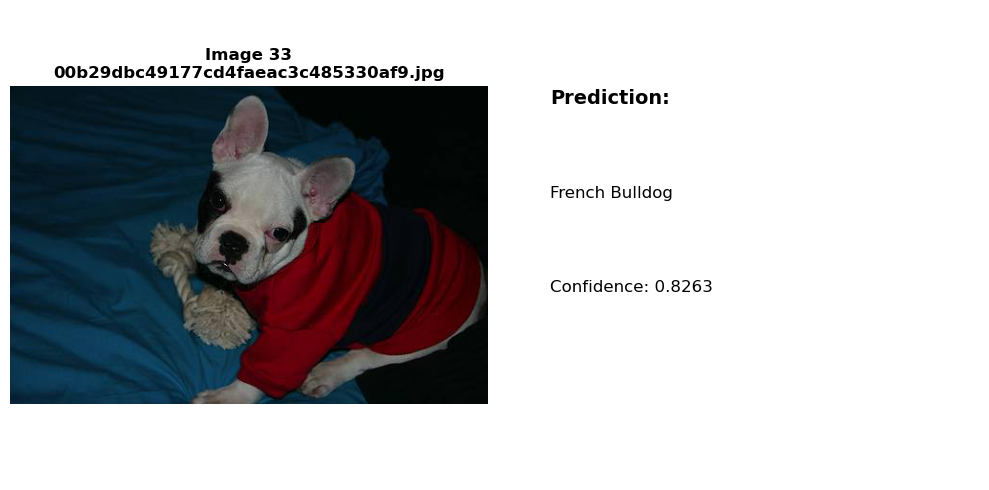

In [7]:
# Getting test image 33
test_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_files.sort()
image_33_path = test_files[33]
print(f"Testing on Image 33: {os.path.basename(image_33_path)}")
    
# Make prediction with attention
result = predict_with_attention(model, processor, image_33_path, BREEDS)
    
if result:
    print(f"Predicted Breed: {result['predicted_breed'].replace('_', ' ').title()}")
    print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
        
    # Display image and prediction
    plt.figure(figsize=(10, 5))
        
    plt.subplot(1, 2, 1)
    plt.imshow(result['original_image'])
    plt.title(f"Image 33\n{os.path.basename(image_33_path)}", fontweight='bold')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.8, f"Prediction:", fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.1, 0.6, f"{result['predicted_breed'].replace('_', ' ').title()}", 
            fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.4, f"Confidence: {result['confidence']:.4f}", 
            fontsize=12, transform=plt.gca().transAxes)
    plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    

In [8]:
custom_images = ['cat.jpg', 'cow.jpg','wolf.jpg','wolf_dog.jpeg','coyote.jpg','fox.jpg','snake.jpg']

In [9]:
for img_name in custom_images:
    img_path = os.path.join(DATA_DIR, img_name)
    
    if os.path.exists(img_path):
        print("-" * 40)
        print(f"\nTesting on: {img_name}")
        print("-" * 40)
        
        # Make prediction with attention
        result = predict_with_attention(model, processor, img_path, BREEDS)
        
        if result['confidence']>0.3:
            print(f"Predicted Breed: {result['predicted_breed'].replace('_', ' ').title()}")
            print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
        else:
            print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
            print("Either not a dog or the image is not clear. Please upload a different image with better resolution and background")

----------------------------------------

Testing on: cat.jpg
----------------------------------------
Confidence: 0.0527 (5.27%)
Either not a dog or the image is not clear. Please upload a different image with better resolution and background
----------------------------------------

Testing on: cow.jpg
----------------------------------------
Confidence: 0.1571 (15.71%)
Either not a dog or the image is not clear. Please upload a different image with better resolution and background
----------------------------------------

Testing on: wolf.jpg
----------------------------------------
Confidence: 0.2444 (24.44%)
Either not a dog or the image is not clear. Please upload a different image with better resolution and background
----------------------------------------

Testing on: wolf_dog.jpeg
----------------------------------------
Confidence: 0.0588 (5.88%)
Either not a dog or the image is not clear. Please upload a different image with better resolution and background
---------------

In [10]:
def attention_overlay_predict(model, processor, image_path, breeds_list, img_size=224):
    """
    Modular function to predict and create attention overlay for any image
    """
    if not os.path.exists(image_path):
        print(f" Image not found: {image_path}")
        return None
    
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()
        image = image.resize((img_size, img_size))
        image_array = np.array(image)
        
        # Preprocess with DeiT processor
        inputs = processor(image_array, return_tensors="tf")
        pixel_values = inputs['pixel_values']
        
        # Predict with attention scores
        predictions, attentions = model(pixel_values, return_attention=True)
        prob_vector = predictions.numpy()[0]
        
        # Get results
        predicted_idx = np.argmax(prob_vector)
        predicted_breed = breeds_list[predicted_idx]
        confidence = prob_vector[predicted_idx]
        
        # Get top 3 predictions
        top_3_indices = np.argsort(prob_vector)[-3:][::-1]
        top_3_breeds = [(breeds_list[i], prob_vector[i]) for i in top_3_indices]
        
        # Process attention for overlay
        last_attention = attentions[-1][0]
        mean_attention = np.mean(last_attention, axis=0)
        cls_attention = mean_attention[0, 1:]
        
        grid_size = int(np.sqrt(cls_attention.shape[0]))
        attention_grid = cls_attention.reshape(grid_size, grid_size)
        attention_resized = tf.image.resize(
            tf.expand_dims(tf.expand_dims(attention_grid, -1), 0), 
            [img_size, img_size]
        ).numpy()[0, :, :, 0]
        
        attention_resized = (attention_resized - attention_resized.min()) / (attention_resized.max() - attention_resized.min() + 1e-8)
        
        # Create visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        ax1.imshow(original_image)
        ax1.set_title(f'Original Image\n{os.path.basename(image_path)}', fontweight='bold')
        ax1.axis('off')
        
        # Attention heatmap
        ax2.imshow(attention_resized, cmap='hot')
        ax2.set_title('Attention Heatmap', fontweight='bold')
        ax2.axis('off')
        
        # Overlay
        ax3.imshow(image_array)
        ax3.imshow(attention_resized, cmap='hot', alpha=0.6)
        ax3.set_title('Attention Overlay', fontweight='bold')
        ax3.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print prediction results
        print(f"Prediction: {predicted_breed.replace('_', ' ').title()}")
        print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
        print("\n Top 3 Predictions:")
        for i, (breed, prob) in enumerate(top_3_breeds):
            print(f"   {i+1}. {breed.replace('_', ' ').title():<25} {prob:.4f} ({prob*100:.2f}%)")
        print("-" * 60)
        
        return {
            'original_image': original_image,
            'predicted_breed': predicted_breed,
            'confidence': confidence,
            'top_3': top_3_breeds,
            'attentions': attentions
        }
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

🔍 Testing on Test Image 33:
--------------------------------------------------


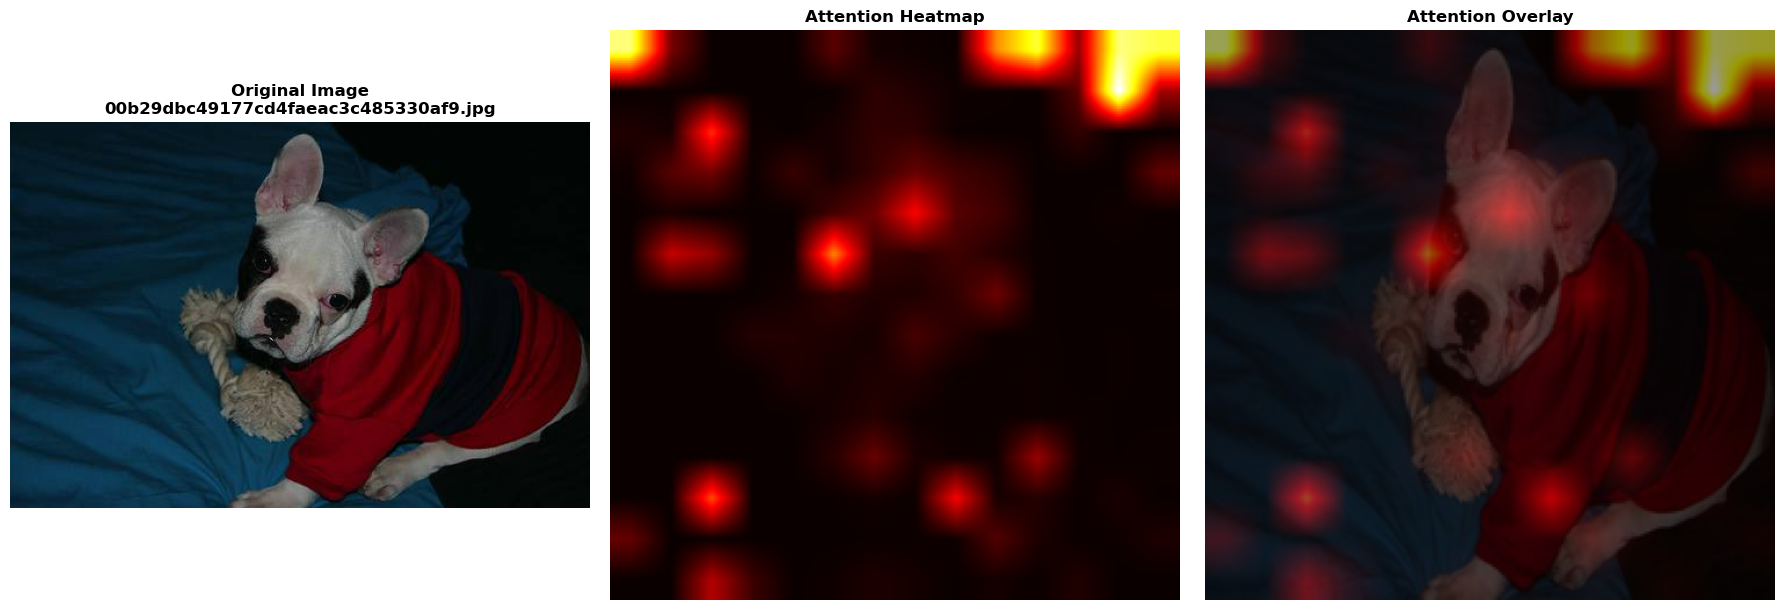

Prediction: French Bulldog
Confidence: 0.8263 (82.63%)

 Top 3 Predictions:
   1. French Bulldog            0.8263 (82.63%)
   2. Boston Bull               0.0204 (2.04%)
   3. Scotch Terrier            0.0078 (0.78%)
------------------------------------------------------------


In [11]:
# Test on image 33 from test folder
test_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_files.sort()
image_33_path = test_files[33]
print("🔍 Testing on Test Image 33:")
print("-" * 50)
result_33 = attention_overlay_predict(model, processor, image_33_path, BREEDS, IMG_SIZE)


🔍 Testing on Custom Images:

📸 Testing on: cat.jpg


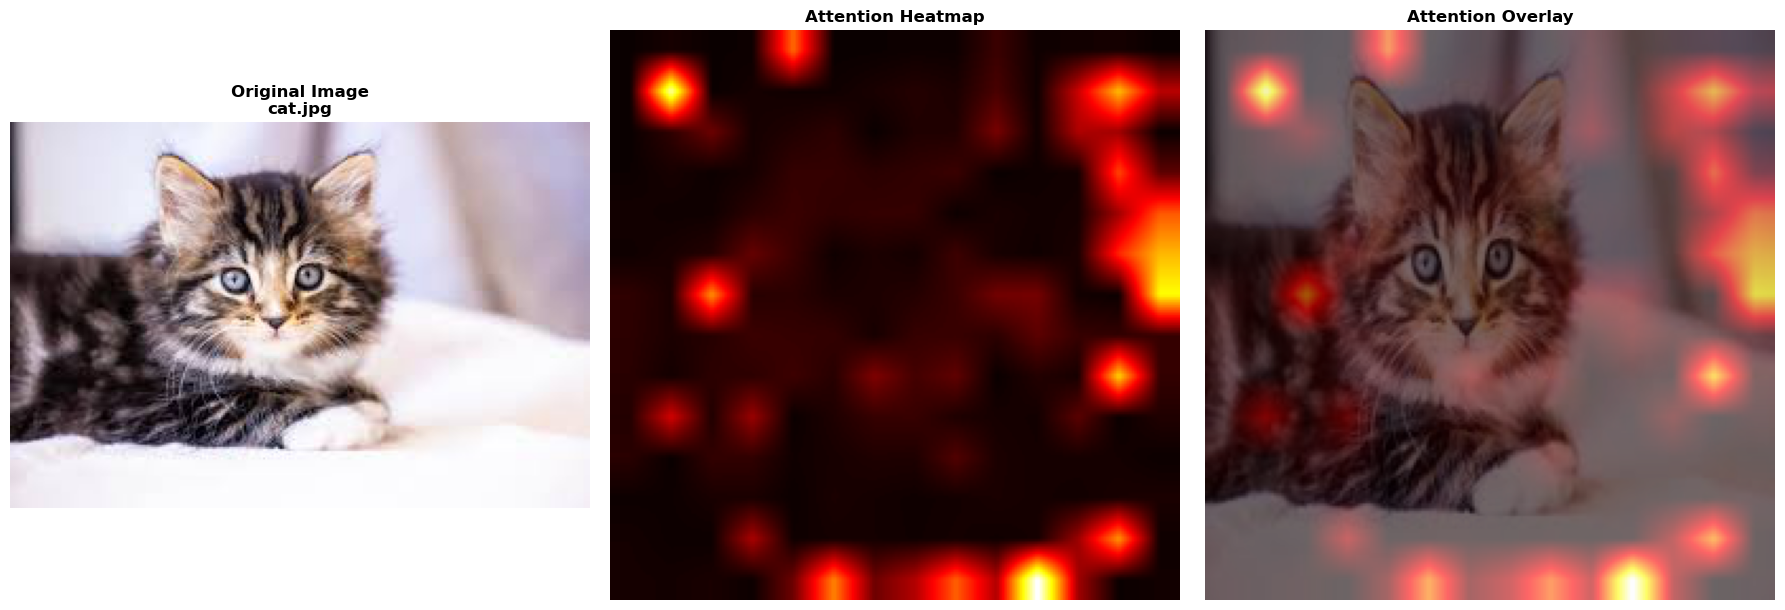

Prediction: Shih-Tzu
Confidence: 0.0527 (5.27%)

 Top 3 Predictions:
   1. Shih-Tzu                  0.0527 (5.27%)
   2. Japanese Spaniel          0.0445 (4.45%)
   3. Doberman                  0.0342 (3.42%)
------------------------------------------------------------

📸 Testing on: cow.jpg


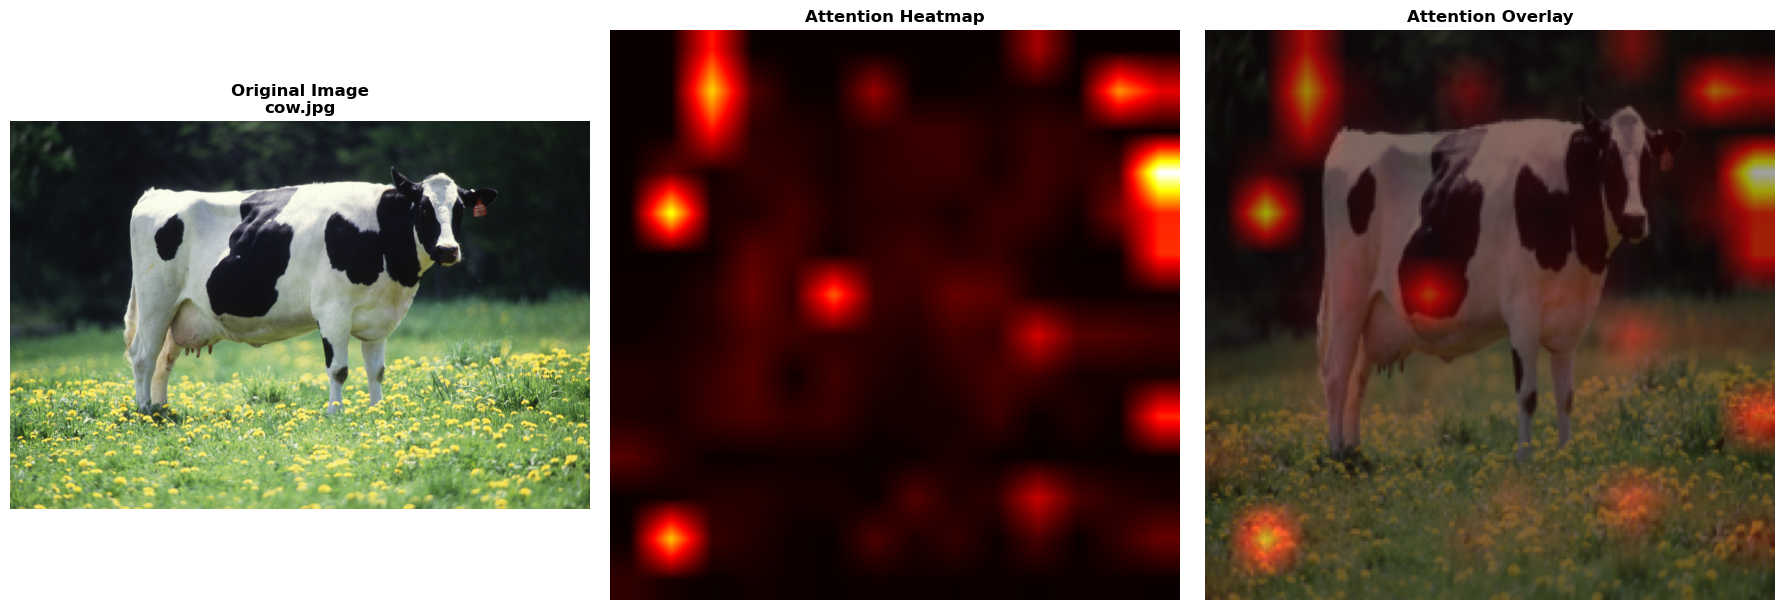

Prediction: Staffordshire Bullterrier
Confidence: 0.1571 (15.71%)

 Top 3 Predictions:
   1. Staffordshire Bullterrier 0.1571 (15.71%)
   2. American Staffordshire Terrier 0.0983 (9.83%)
   3. Pug                       0.0714 (7.14%)
------------------------------------------------------------

📸 Testing on: wolf.jpg


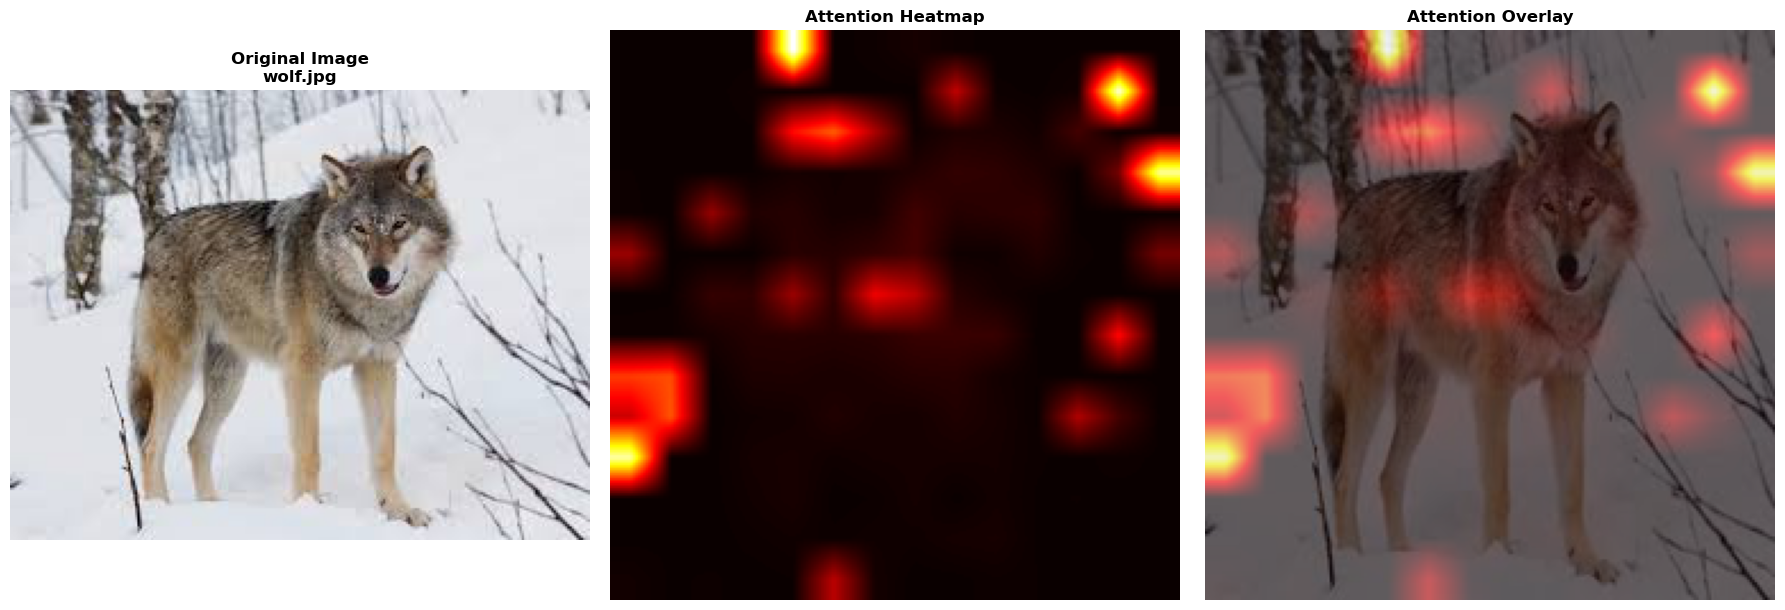

Prediction: Dhole
Confidence: 0.2444 (24.44%)

 Top 3 Predictions:
   1. Dhole                     0.2444 (24.44%)
   2. Dingo                     0.1199 (11.99%)
   3. African Hunting Dog       0.0672 (6.72%)
------------------------------------------------------------

📸 Testing on: wolf_dog.jpeg


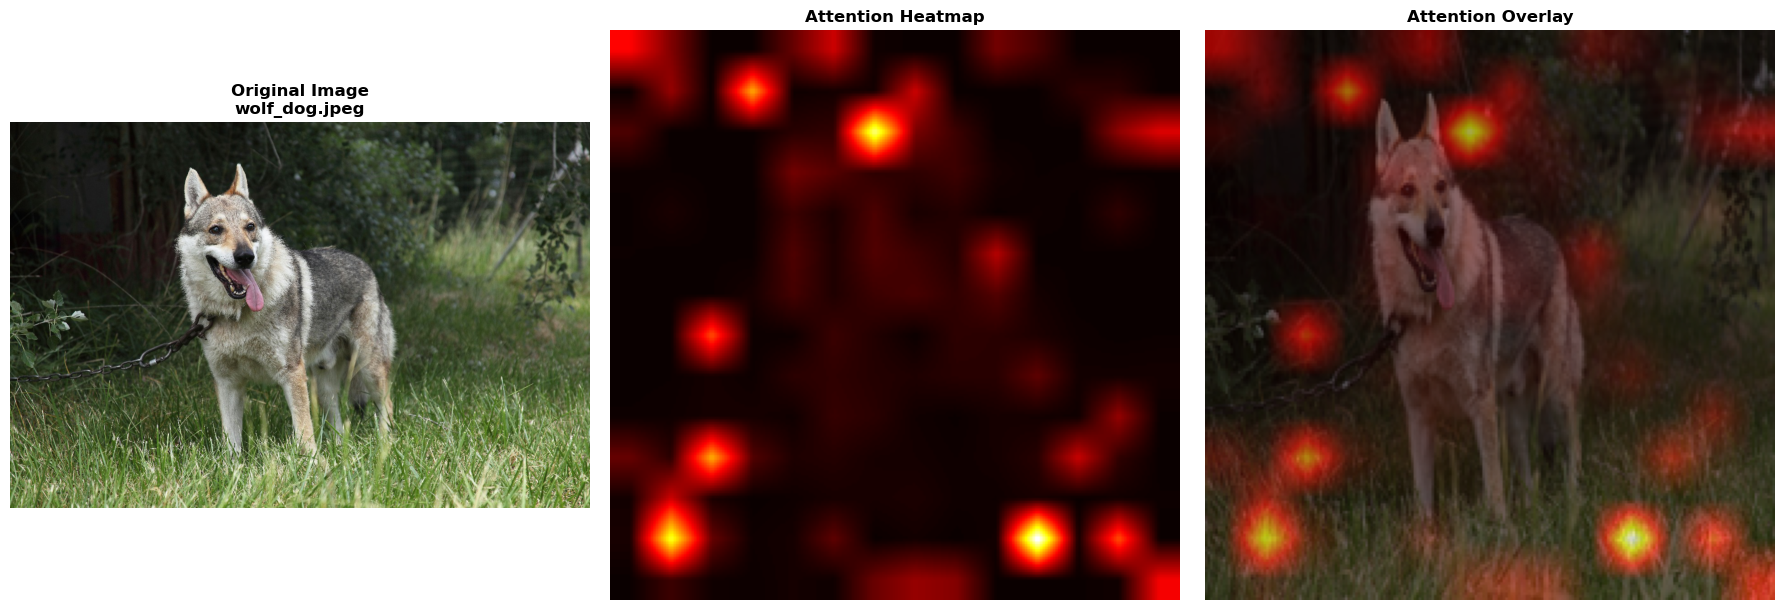

Prediction: Eskimo Dog
Confidence: 0.0588 (5.88%)

 Top 3 Predictions:
   1. Eskimo Dog                0.0588 (5.88%)
   2. Dingo                     0.0412 (4.12%)
   3. Japanese Spaniel          0.0338 (3.38%)
------------------------------------------------------------

📸 Testing on: coyote.jpg


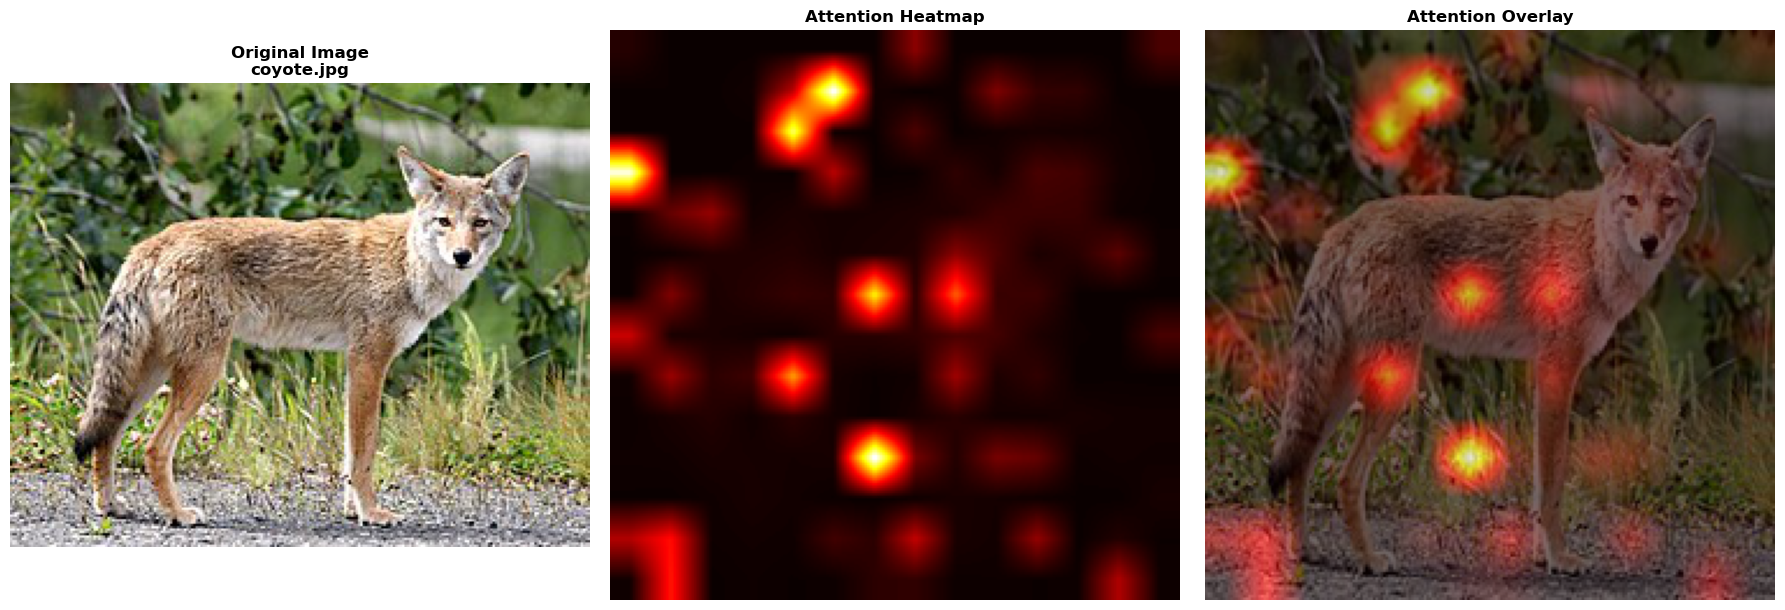

Prediction: Dhole
Confidence: 0.2728 (27.28%)

 Top 3 Predictions:
   1. Dhole                     0.2728 (27.28%)
   2. Pekinese                  0.0383 (3.83%)
   3. Border Terrier            0.0327 (3.27%)
------------------------------------------------------------

📸 Testing on: fox.jpg


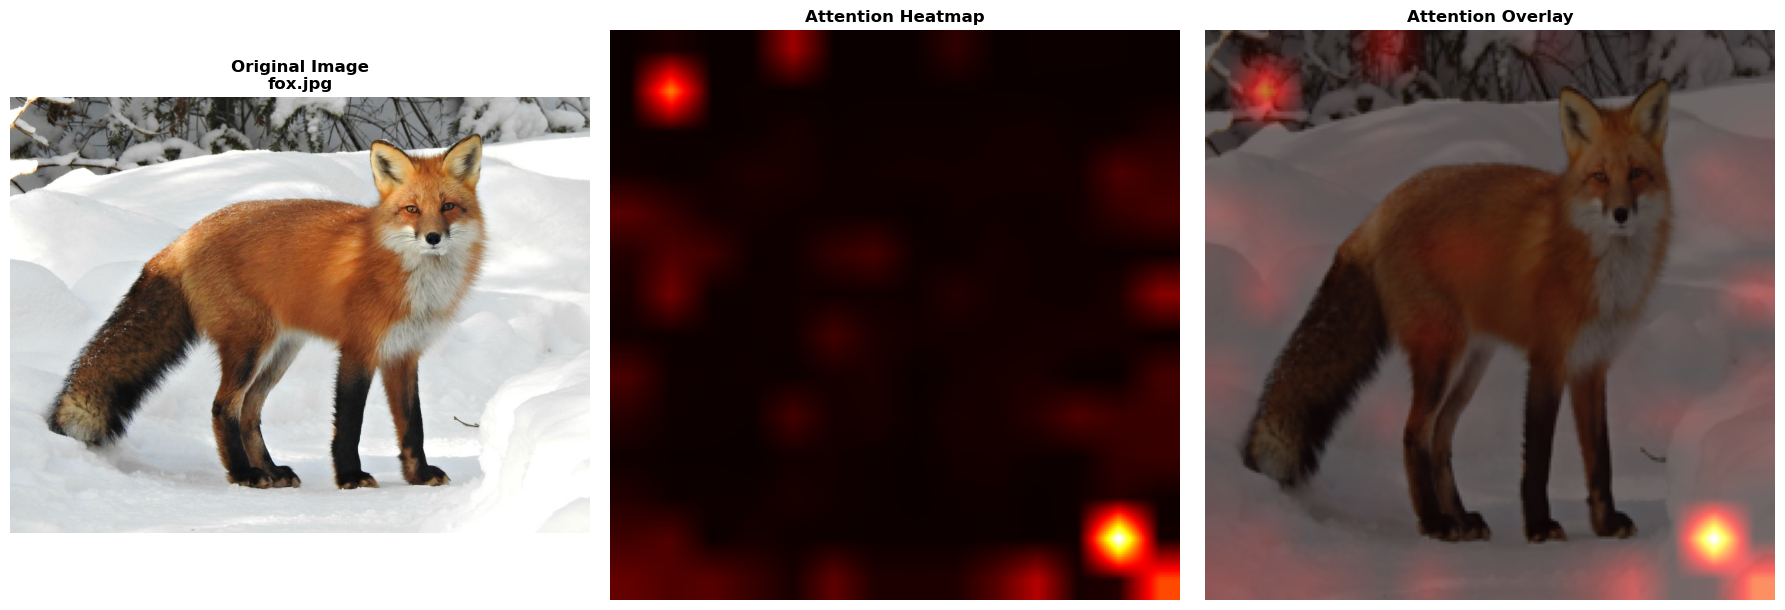

Prediction: Boxer
Confidence: 0.0652 (6.52%)

 Top 3 Predictions:
   1. Boxer                     0.0652 (6.52%)
   2. Dhole                     0.0571 (5.71%)
   3. Irish Terrier             0.0488 (4.88%)
------------------------------------------------------------

📸 Testing on: snake.jpg


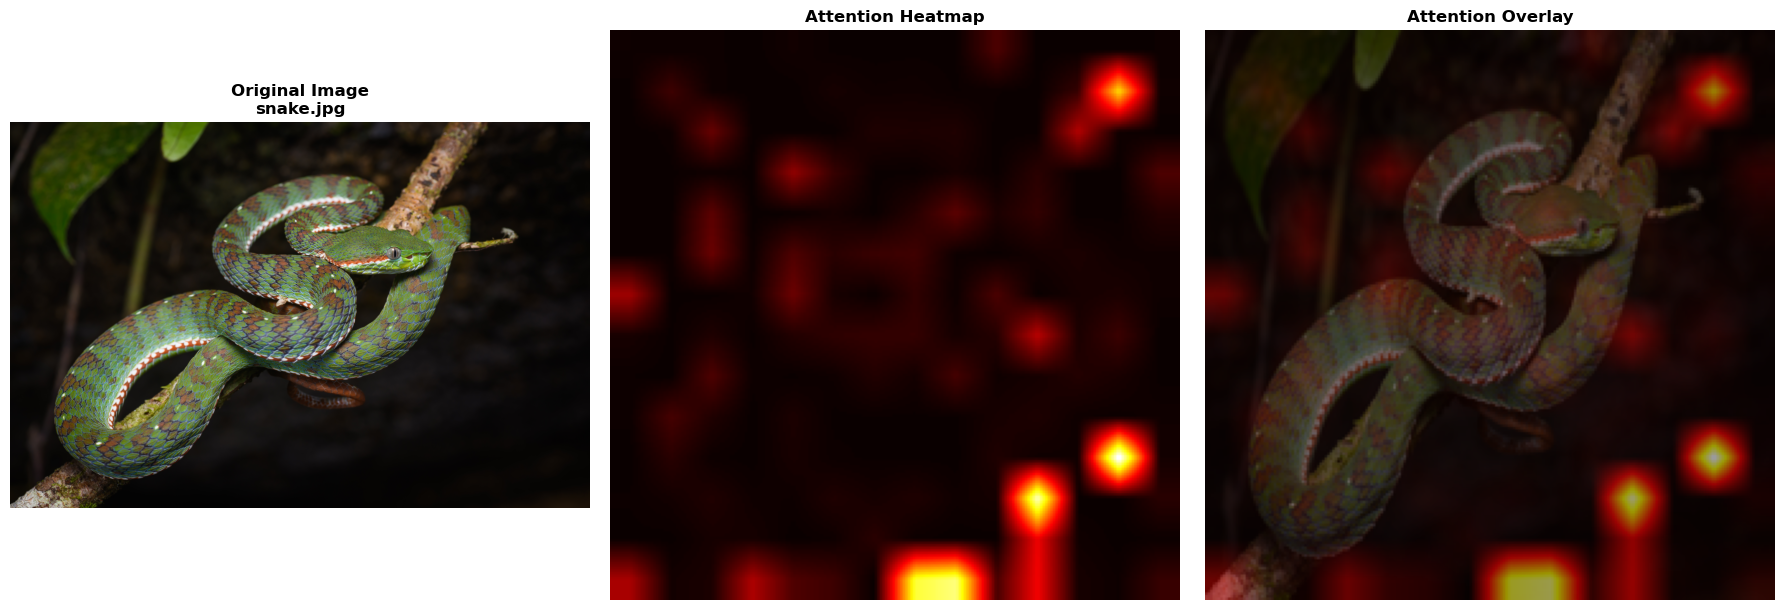

Prediction: Pekinese
Confidence: 0.0612 (6.12%)

 Top 3 Predictions:
   1. Pekinese                  0.0612 (6.12%)
   2. Shih-Tzu                  0.0478 (4.78%)
   3. English Foxhound          0.0408 (4.08%)
------------------------------------------------------------


In [12]:
# Test on custom images in main directory
print("\n🔍 Testing on Custom Images:")
print("=" * 50)

for img_name in custom_images:
    img_path = os.path.join(DATA_DIR, img_name)
    if os.path.exists(img_path):
        print(f"\n📸 Testing on: {img_name}")
        result = attention_overlay_predict(model, processor, img_path, BREEDS, IMG_SIZE)
    else:
        print(f"❌ Image not found: {img_name}")